# <center>Kaggle соревнование по чозданию модели о предсказании рейтинга отеля

In [198]:
import numpy as np
import pandas as pd
import time
import plotly
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import statistics
from scipy import stats 
from sklearn import preprocessing
# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [199]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [200]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

## 1. Ознакомление с данными

In [201]:
# загрузим все необходимые фаилы

df_test = pd.read_csv('data/hotels_test.csv')
df_train = pd.read_csv('data/hotels_train.csv')
sample_submission = pd.read_csv('data/submission.csv')

In [202]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [203]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [204]:
sample_submission.head()

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596


In [205]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

C:\Users\Павел\AppData\Local\Temp\ipykernel_12864\447817491.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем


In [206]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

## 2. Очистка данных

In [207]:
# удалим не важные столбцы географической долготы и широты, так как в строках мы имеем название городов
data.drop(['lat', 'lng'], axis = 1, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

In [208]:
# вычислим полные дубликаты по строкам, для этого создадим список из столбцов, 
# затем создадим маску для поиска по строкам и вычислим сколько идентичных совпадений,
# после этого создадим копию DF и удалим оттуда все дубликаты
dupl_columns = list(data.columns)
mask = data.duplicated(subset=dupl_columns)
data_duplicates = data[mask]
print(f'Число найденных дубликатов: {data_duplicates.shape[0]}')


Число найденных дубликатов: 336


## 3. EDA 

In [209]:
# из строкового значения города найдем уникальные
print('Количество уникальных адресов: ' + str(data['hotel_address'].nunique())+'\n') 
print(data['hotel_address'].value_counts().sample(10))

Количество уникальных адресов: 1493

53 Rue Richard Lenoir 11th arr 75011 Paris France                             34
Whitehall Place Westminster Borough London SW1A 2BD United Kingdom           213
2 place Louis Armand 12th arr 75012 Paris France                             411
5 More London Place Tooley Street Southwark London SE1 2BY United Kingdom    801
5 rue des Capucines 1st arr 75001 Paris France                               116
10 Rue de la Tour d Auvergne 9th arr 75009 Paris France                       25
153 Hammersmith Road Hammersmith and Fulham London W14 0QL United Kingdom    381
Gr nentorgasse 30 09 Alsergrund 1090 Vienna Austria                           93
60 rue Richer 9th arr 75009 Paris France                                      45
Via Tiziano 6 Fiera Milano City 20145 Milan Italy                             61
Name: hotel_address, dtype: int64


*Исходя из приведенного выше кода можно сделать вывод о том, что страна содержится в последних двух значениях строки(united kingdom), следовательно для опеределния  страны мы можем их использовать в дальнейшем и выделить при помоши срезов, так как страна может повлиять на положительную оценку отзыва*

In [210]:
data['hotel_country'] = data['hotel_address'].apply(lambda x: x.split()[-1] if x.split()[-1] != 'Kingdom' else ' '.join(x.split()[-2:]))
data['hotel_country']

0                  Italy
1            Netherlands
2                  Spain
3                  Italy
4            Netherlands
               ...      
515733    United Kingdom
515734           Austria
515735    United Kingdom
515736    United Kingdom
515737    United Kingdom
Name: hotel_country, Length: 515738, dtype: object

In [211]:
# закодируем страны при помоши one_hotEncoding
import category_encoders as ce
encoder = ce.OneHotEncoder(cols=['hotel_country'], use_cat_names=True)
country_encoded = encoder.fit_transform(data['hotel_country'])
data = pd.concat([data, country_encoded], axis= 1)

data.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,...,days_since_review,sample,reviewer_score,hotel_country,hotel_country_Italy,hotel_country_Netherlands,hotel_country_Spain,hotel_country_United Kingdom,hotel_country_France,hotel_country_Austria
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,...,13 days,0,0.0,Italy,1,0,0,0,0,0
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,...,234 day,0,0.0,Netherlands,0,1,0,0,0,0
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,...,616 day,0,0.0,Spain,0,0,1,0,0,0


In [212]:
# извлекем из адреса отеля города в которых они расположены
data['hotel_city'] = data['hotel_address'].apply(lambda x: x.split()[-2] if x.split()[-1] != 'Kingdom' else x.split()[-5])
print('Количество городов в датасете '+str(data['hotel_city'].nunique()))
print(data['hotel_city'].value_counts())

Количество городов в датасете 6
London       262301
Barcelona     60149
Paris         59928
Amsterdam     57214
Vienna        38939
Milan         37207
Name: hotel_city, dtype: int64


In [213]:
# закодируем города при помоши oneHotEncoding

encoder = ce.OneHotEncoder(cols=['hotel_city'], use_cat_names=True)
city_encoded = encoder.fit_transform(data['hotel_city'])
data = pd.concat([data, city_encoded], axis= 1)

data.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,...,hotel_country_United Kingdom,hotel_country_France,hotel_country_Austria,hotel_city,hotel_city_Milan,hotel_city_Amsterdam,hotel_city_Barcelona,hotel_city_London,hotel_city_Paris,hotel_city_Vienna
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,...,0,0,0,Milan,1,0,0,0,0,0
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,...,0,0,0,Amsterdam,0,1,0,0,0,0
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,...,0,0,0,Barcelona,0,0,1,0,0,0


In [214]:
# Преобразуем столбец review-data  в года, месяцы, день, день недели
data['review_date'] = pd.to_datetime(data['review_date'])

# Создаем столбцы year, day, month, weekday
data['year'] = data['review_date'].dt.year
data['day'] = data['review_date'].dt.day
data['month'] = data['review_date'].dt.month
data['weekday'] = data['review_date'].dt.weekday + 1 

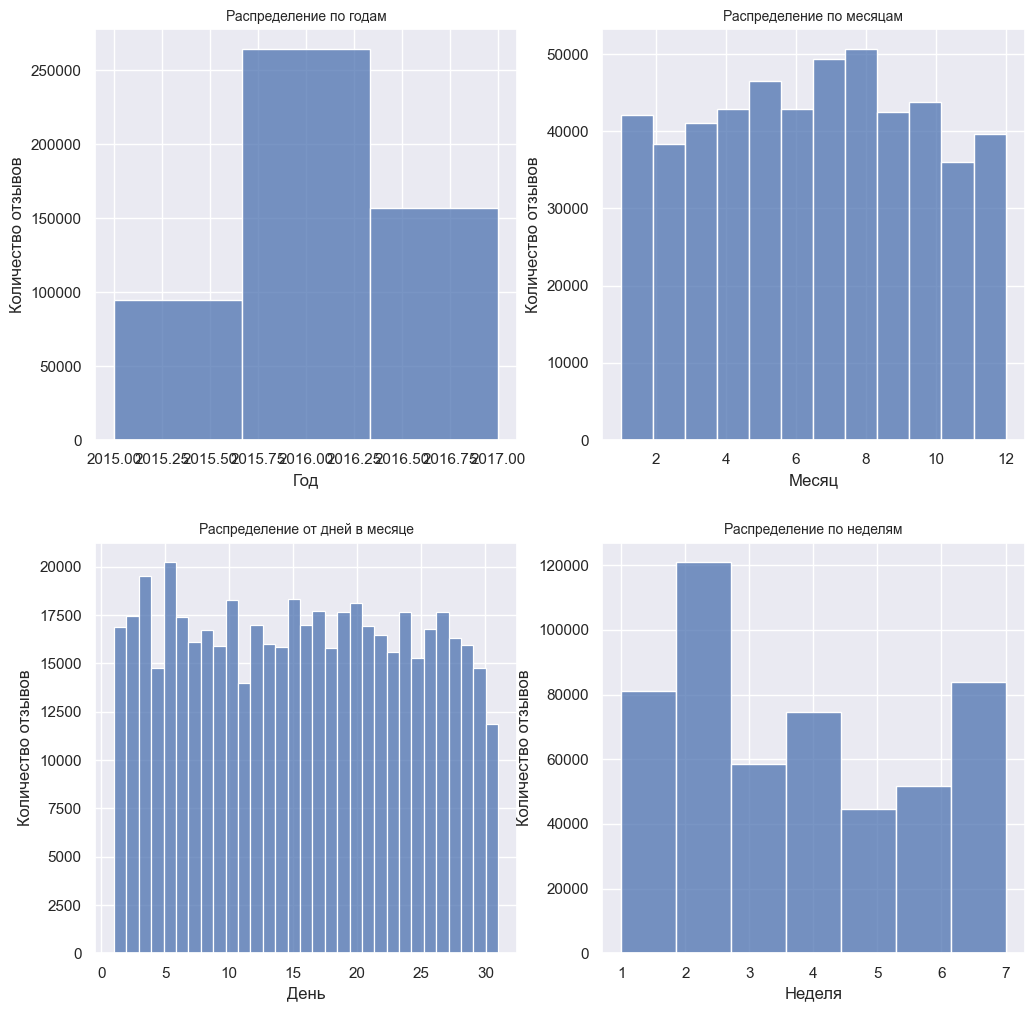

In [215]:
# создадим графики, зависимости распределения отзывов по признакам
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
plt.subplots_adjust(hspace=.25)

histplot1 = sns.histplot(data=data, x='year', bins=3, ax=axes[0,0])
histplot1.set_title('Распределение по годам', fontsize=10)
histplot1.set_xlabel('Год')
histplot1.set_ylabel('Количество отзывов')



histplot2 = sns.histplot(data=data, x='month', bins=12, ax=axes[0,1])
histplot2.set_title('Распределение по месяцам', fontsize=10)
histplot2.set_xlabel('Месяц')
histplot2.set_ylabel('Количество отзывов')

histplot3 = sns.histplot(data=data, x='day', bins=31, ax=axes[1,0])
histplot3.set_title('Распределение от дней в месяце', fontsize=10)
histplot3.set_xlabel('День')
histplot3.set_ylabel('Количество отзывов')

histplot3 = sns.histplot(data=data, x='weekday', bins=7, ax=axes[1,1])
histplot3.set_title('Распределение по неделям', fontsize=10)
histplot3.set_xlabel('Неделя')
histplot3.set_ylabel('Количество отзывов');

In [216]:
data['reviewer_nationality'] = data['reviewer_nationality'].apply(lambda s: s.strip())
print('Количество уникальных значений в национальности ревьюера  ' + str(data['reviewer_nationality'].nunique()))

Количество уникальных значений в национальности ревьюера  227


In [217]:
# СОздадим признак, где 1- национальность ревьюера совпадает с расположением отеля, 0- не совпадают
data['local_reviewer'] = data.apply(lambda x: 1 if x['reviewer_nationality'] == x['hotel_country'] else 0, axis=1)
data['local_reviewer'].value_counts(normalize=True)

0    0.654082
1    0.345918
Name: local_reviewer, dtype: float64

In [218]:
n = 7
popular_reviewer_nationalities = data['reviewer_nationality'].value_counts().nlargest(n).index
data['reviewer_nationality'] = data['reviewer_nationality'].apply(lambda x: x if x in popular_reviewer_nationalities else 'Other')
data['reviewer_nationality'].value_counts(normalize=True)

United Kingdom              0.475524
Other                       0.330757
United States of America    0.068711
Australia                   0.042048
Ireland                     0.028749
United Arab Emirates        0.019845
Saudi Arabia                0.017356
Netherlands                 0.017009
Name: reviewer_nationality, dtype: float64

In [219]:
# Также закодируем страну ревьюера через OneHotEncoding
ohe_country = ce.OneHotEncoder(cols=['reviewer_nationality'], use_cat_names=True)
encodes = ohe_country.fit_transform(data['reviewer_nationality'])
data = pd.concat([data, encodes], axis=1)

In [220]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 43 columns):
 #   Column                                         Non-Null Count   Dtype         
---  ------                                         --------------   -----         
 0   hotel_address                                  515738 non-null  object        
 1   additional_number_of_scoring                   515738 non-null  int64         
 2   review_date                                    515738 non-null  datetime64[ns]
 3   average_score                                  515738 non-null  float64       
 4   hotel_name                                     515738 non-null  object        
 5   reviewer_nationality                           515738 non-null  object        
 6   negative_review                                515738 non-null  object        
 7   review_total_negative_word_counts              515738 non-null  int64         
 8   total_number_of_reviews                     

In [221]:
# При помоши билиотеки nltk проанализируем отзывы
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import time
nltk.downloader.download('vader_lexicon')

sent_analyzer = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Павел\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [222]:
data['polarity_scores'] = data['negative_review'].apply(sent_analyzer.polarity_scores)


data['n_neg'] = data['polarity_scores'].apply(lambda x: x['neg'])
data['n_neu'] = data['polarity_scores'].apply(lambda x: x['neu'])
data['n_pos'] = data['polarity_scores'].apply(lambda x: x['pos'])
data['n_compound'] = data['polarity_scores'].apply(lambda x: x['compound'])

data.drop('polarity_scores', axis=1, inplace=True)

In [223]:
data['polarity_scores'] = data['positive_review'].apply(sent_analyzer.polarity_scores)

data['p_neg'] = data['polarity_scores'].apply(lambda x: x['neg'])
data['p_neu'] = data['polarity_scores'].apply(lambda x: x['neu'])
data['p_pos'] = data['polarity_scores'].apply(lambda x: x['pos'])
data['p_compound'] = data['polarity_scores'].apply(lambda x: x['compound'])

data.drop('polarity_scores', axis=1, inplace=True)

### Проанализируем числовые переменные

Text(0.5, 1.0, 'Количество отзывов от ревьюера')

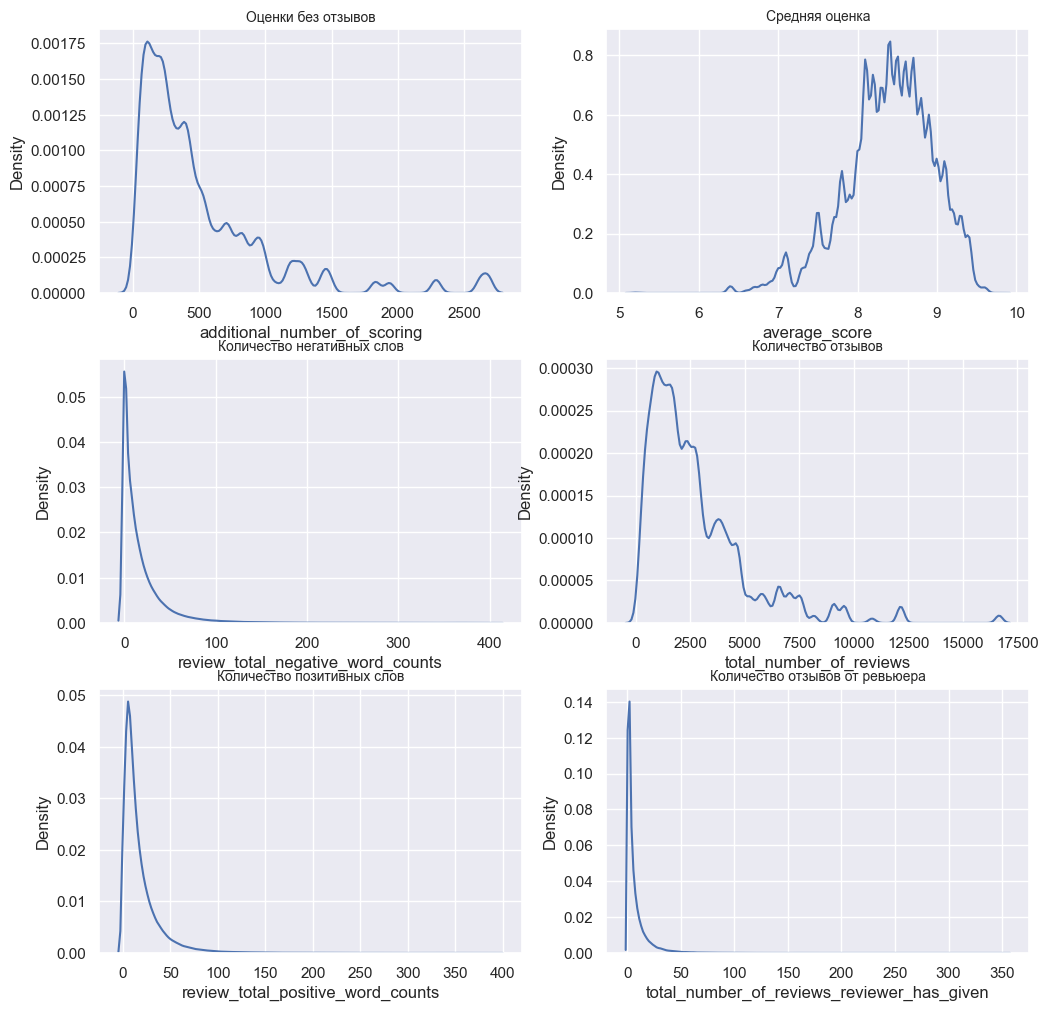

In [224]:
# зададим параметры холста, название и визуализируем кривые распределения:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 12))
plt.subplots_adjust(hspace=.25)


# kdeplot() (KDE – оценка плотности ядра) – специальный метод для графиков распределений
kde1 = sns.kdeplot(data['additional_number_of_scoring'], ax=axes[0,0])
kde1.set_title('Оценки без отзывов', fontsize=10)

kde2 = sns.kdeplot(data['average_score'], ax=axes[0,1])
kde2.set_title('Средняя оценка', fontsize=10)

kde3 = sns.kdeplot(data['review_total_negative_word_counts'], ax=axes[1,0])
kde3.set_title('Количество негативных слов', fontsize=10)

kde4 = sns.kdeplot(data['total_number_of_reviews'], ax=axes[1,1])
kde4.set_title('Количество отзывов', fontsize=10)

kde5 = sns.kdeplot(data['review_total_positive_word_counts'], ax=axes[2,0])
kde5.set_title('Количество позитивных слов', fontsize=10)

kde6 = sns.kdeplot(data['total_number_of_reviews_reviewer_has_given'], ax=axes[2,1])
kde6.set_title('Количество отзывов от ревьюера', fontsize=10)


In [225]:
# Проверим описание каждой группы
data[['additional_number_of_scoring', 'average_score', 
    'review_total_negative_word_counts', 'total_number_of_reviews', 
    'review_total_positive_word_counts', 'total_number_of_reviews_reviewer_has_given']
].describe()

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given
count,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000
mean,498.081836,8.397487,18.539450,2743.743944,17.776458,7.166001
std,500.538467,0.548048,29.690831,2317.464868,21.804185,11.040228
min,1.000000,5.200000,0.000000,43.000000,0.000000,1.000000
25%,169.000000,8.100000,2.000000,1161.000000,5.000000,1.000000
50%,341.000000,8.400000,9.000000,2134.000000,11.000000,3.000000
75%,660.000000,8.800000,23.000000,3613.000000,22.000000,8.000000
max,2682.000000,9.800000,408.000000,16670.000000,395.000000,355.000000


In [226]:
# Проверим параметр на нормальность
# нулевая и альтернативная гипотезы
H0 = 'Распределения нормальное'
H1 = 'Распределение не нормальное'
alpha = 0.05 # уровень значимости
# вычисляем результат теста Шапиро-Уилка для выборок
shapiro = stats.shapiro(data['average_score'])

print('p-value группы А', round(shapiro.pvalue, 2))


# сравниваем полученное p-value с уровнем значимости
if shapiro.pvalue < alpha:
    print(f'Отвергаем нулевую гипотезу. {H0}')
    print(f'Альтернативная гипотеза H1 {H1}')
else:
    print(f'Принимаем нулевую гипотезу {H0}')    

p-value группы А 0.0
Отвергаем нулевую гипотезу. Распределения нормальное
Альтернативная гипотеза H1 Распределение не нормальное


c:\Users\Павел\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


*Исходя из представленных графиков, можно сделать вывод о том, что в каждом из признаков наблюдаются выбросы, так как они не распределены нормально, данные признаки необходимо **нормализовать**, что в дальнейшем и проведем при помоши метода RobustScaler*

In [227]:
# Создание экземпляра класса RobustScaler()
robust_scaler = preprocessing.RobustScaler()
# Маштабируем признаки
data['additional_number_of_scoring'] = robust_scaler.fit_transform(data[['additional_number_of_scoring']])

data['average_score'] = robust_scaler.fit_transform(data[['average_score']])

data['review_total_negative_word_counts'] = robust_scaler.fit_transform(data[['review_total_negative_word_counts']])

data['total_number_of_reviews'] = robust_scaler.fit_transform(data[['total_number_of_reviews']])

data['review_total_positive_word_counts'] = robust_scaler.fit_transform(data[['review_total_positive_word_counts']])

data['total_number_of_reviews_reviewer_has_given'] = robust_scaler.fit_transform(data[['total_number_of_reviews_reviewer_has_given']])

# Проверим описание каждой группы после маштабирования
data[['additional_number_of_scoring', 'average_score', 
    'review_total_negative_word_counts', 'total_number_of_reviews', 
    'review_total_positive_word_counts', 'total_number_of_reviews_reviewer_has_given']
].describe()


,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given
count,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000
mean,0.319922,-0.003590,0.454260,0.248672,0.398615,0.595143
std,1.019427,0.782926,1.413849,0.945132,1.282599,1.577175
min,-0.692464,-4.571429,-0.428571,-0.852773,-0.647059,-0.285714
25%,-0.350305,-0.428571,-0.333333,-0.396819,-0.352941,-0.285714
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.649695,0.571429,0.666667,0.603181,0.647059,0.714286
max,4.767821,2.000000,19.000000,5.928222,22.588235,50.285714


*Преобразуем столбез 'days_scince_review' в числовую, для этого разобьем каждое значение и выташим от туда только количество дней*

In [228]:
data['days_since_review'] = data['days_since_review'].apply(lambda x: x.split()[0])

In [229]:
data['days_since_review'] = data['days_since_review'].astype(int)

In [230]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 51 columns):
 #   Column                                         Non-Null Count   Dtype         
---  ------                                         --------------   -----         
 0   hotel_address                                  515738 non-null  object        
 1   additional_number_of_scoring                   515738 non-null  float64       
 2   review_date                                    515738 non-null  datetime64[ns]
 3   average_score                                  515738 non-null  float64       
 4   hotel_name                                     515738 non-null  object        
 5   reviewer_nationality                           515738 non-null  object        
 6   negative_review                                515738 non-null  object        
 7   review_total_negative_word_counts              515738 non-null  float64       
 8   total_number_of_reviews                     

Наиболее высокая корреляция между признаками:


,level_0,level_1,0
725,hotel_city_Barcelona,hotel_country_Spain,1.000000
682,hotel_city_Amsterdam,hotel_country_Netherlands,1.000000
639,hotel_city_Milan,hotel_country_Italy,1.000000
608,hotel_country_Austria,hotel_city_Vienna,1.000000
565,hotel_country_France,hotel_city_Paris,1.000000
522,hotel_country_United Kingdom,hotel_city_London,1.000000
1504,n_neu,n_neg,0.944721
343,reviewer_score,sample,0.931753
1678,p_neu,p_pos,0.924298
888,year,days_since_review,0.917266


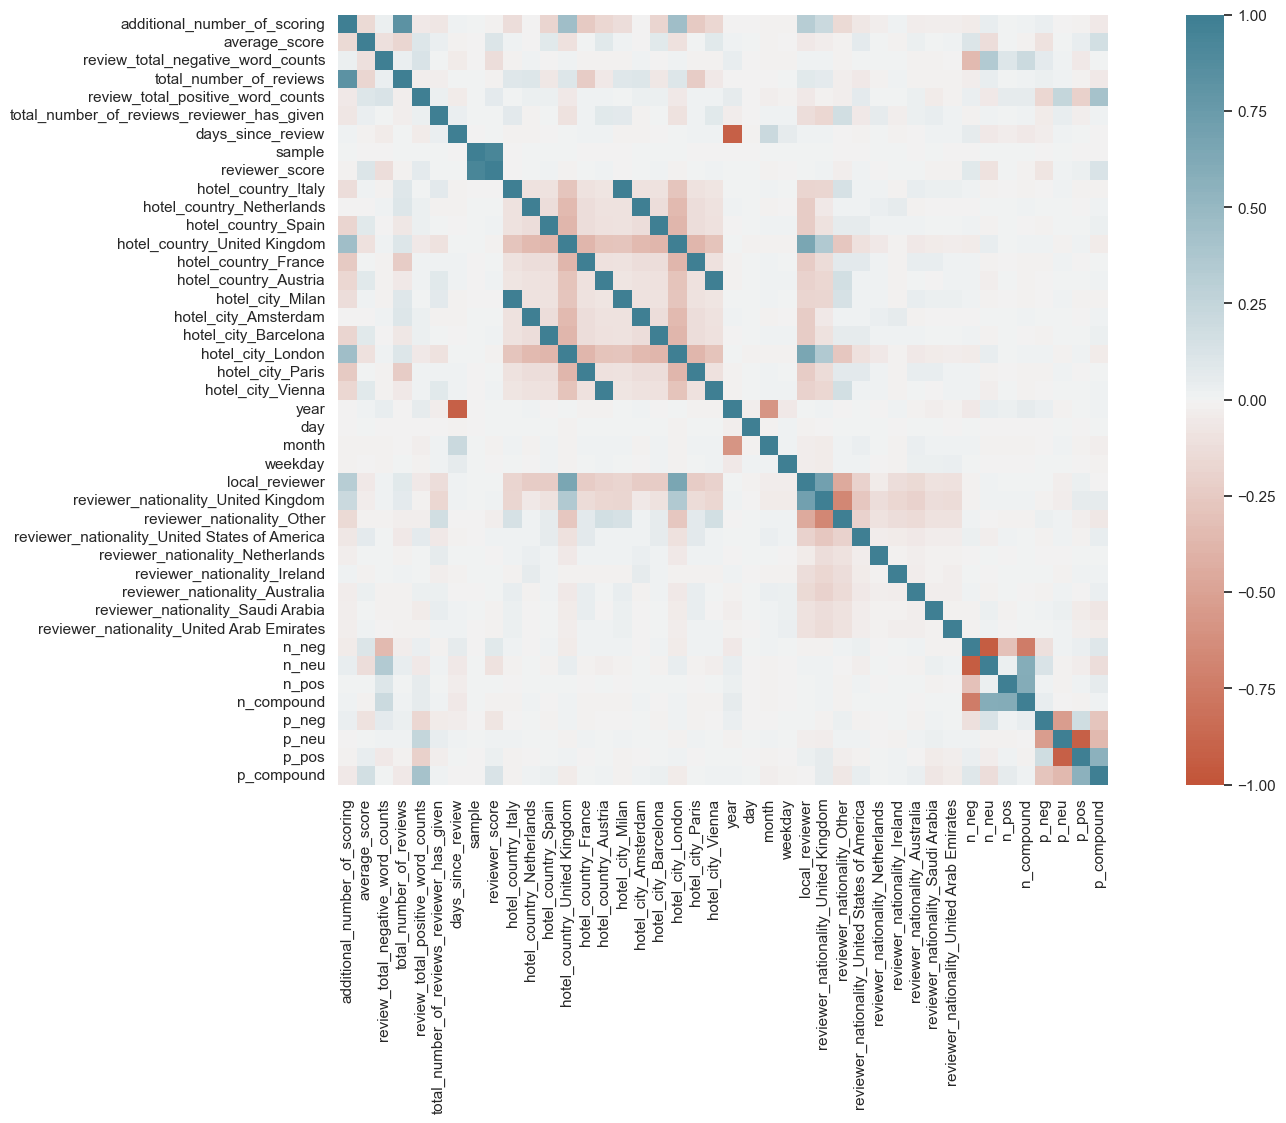

In [231]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности
corr = data.corr()
sns.set(rc={'figure.figsize':(20, 10)})
ax = sns.heatmap(
    corr, 
    vmin=-1, 
    vmax=1, 
    center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
);
print('Наиболее высокая корреляция между признаками:')
corr_unstack = corr.abs().unstack().reset_index()
corr_unstack = corr_unstack.sort_values(by=[0], ascending=False)
mask = corr_unstack['level_0'] != corr_unstack['level_1']
corr_unstack = corr_unstack[mask]
corr_unstack['pr1'] = corr_unstack['level_0'] + corr_unstack['level_1']
corr_unstack['pr1'] = corr_unstack['pr1'].apply(lambda x: ''.join(sorted(list(x))))
corr_unstack = corr_unstack.drop_duplicates(subset=['pr1'])
corr_unstack = corr_unstack.drop(['pr1'], axis=1)
corr_unstack.iloc[:20, :]

In [232]:
#Удалим признаки с корреляцией больше 0.75
drop_list = list()
drop_list.append('n_neg')
drop_list.append('p_pos')
drop_list.append('total_number_of_reviews')


In [233]:
#удаляем признаки которые задавали в список для удаления drop_list
data.drop(drop_list, axis = 1, inplace=True)

In [234]:
# убираем признаки которые еще не успели обработать, 
# модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
object_columns = [s for s in data.columns if data[s].dtypes == 'object']
data.drop(object_columns, axis = 1, inplace=True)

In [235]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 40 columns):
 #   Column                                         Non-Null Count   Dtype         
---  ------                                         --------------   -----         
 0   additional_number_of_scoring                   515738 non-null  float64       
 1   review_date                                    515738 non-null  datetime64[ns]
 2   average_score                                  515738 non-null  float64       
 3   review_total_negative_word_counts              515738 non-null  float64       
 4   review_total_positive_word_counts              515738 non-null  float64       
 5   total_number_of_reviews_reviewer_has_given     515738 non-null  float64       
 6   days_since_review                              515738 non-null  int32         
 7   sample                                         515738 non-null  int64         
 8   reviewer_score                              

In [236]:
data = data.drop(['review_date'],axis=1)

In [237]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

In [238]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [239]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 38), (386803, 38), (386803, 37), (309442, 37), (77361, 37))

In [240]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [241]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [242]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   28.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.4min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.8s finished


In [243]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAPE:', metrics.mean_absolute_error(y_test, y_pred))

MAPE: 0.8786751028726788


<AxesSubplot: >

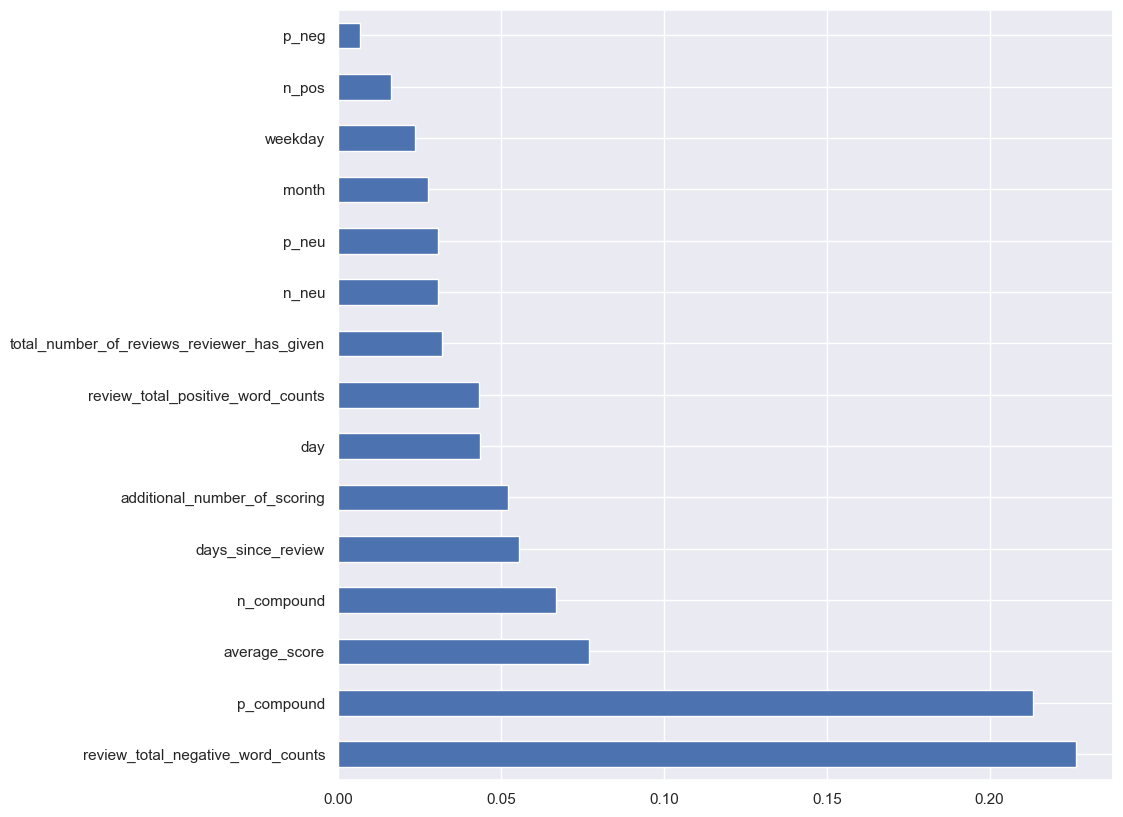

In [244]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [245]:
test_data.sample(10)

,additional_number_of_scoring,average_score,review_total_negative_word_counts,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,days_since_review,reviewer_score,hotel_country_Italy,hotel_country_Netherlands,hotel_country_Spain,...,reviewer_nationality_Ireland,reviewer_nationality_Australia,reviewer_nationality_Saudi Arabia,reviewer_nationality_United Arab Emirates,n_neu,n_pos,n_compound,p_neg,p_neu,p_compound
31610,0.258656,-1.000000,2.571429,2.941176,0.285714,416,0.0,0,0,0,...,0,0,0,0,0.819,0.109,0.3182,0.000,0.722,0.9552
3493,1.460285,-1.000000,7.952381,0.117647,0.285714,606,0.0,0,0,0,...,0,0,0,0,0.816,0.093,0.3336,0.000,0.600,0.7184
110110,-0.226069,0.285714,-0.428571,-0.352941,4.000000,54,0.0,0,0,0,...,0,0,0,0,0.000,0.000,-0.7096,0.000,0.732,0.0258
80371,0.036660,1.285714,-0.428571,1.882353,0.428571,367,0.0,0,0,0,...,0,0,0,0,0.000,0.000,-0.7096,0.000,0.811,0.8122
29694,-0.415479,0.285714,-0.285714,7.470588,1.571429,553,0.0,0,0,0,...,0,0,0,0,1.000,0.000,0.0000,0.054,0.621,0.9945
104694,-0.556008,-0.857143,-0.428571,-0.058824,1.857143,95,0.0,0,0,0,...,0,0,0,0,0.000,0.000,-0.7096,0.000,0.667,0.5413
124034,-0.026477,-1.285714,1.095238,0.000000,-0.285714,308,0.0,0,0,0,...,0,0,0,0,0.898,0.000,-0.5256,0.000,0.728,0.4576
117287,-0.052953,1.428571,-0.095238,1.647059,2.428571,256,0.0,0,0,0,...,0,0,0,0,0.733,0.267,0.2075,0.000,0.902,0.5719
116005,-0.052953,1.285714,0.333333,1.588235,-0.285714,404,0.0,0,0,1,...,0,0,0,0,1.000,0.000,0.0000,0.051,0.654,0.9118
125468,0.099796,-0.571429,1.380952,-0.647059,0.571429,499,0.0,0,0,0,...,0,0,0,0,0.825,0.120,0.3818,0.379,0.000,0.3400


In [246]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [247]:
sample_submission

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596
...,...,...
128930,7,495812
128931,1,315577
128932,3,511968
128933,6,303386


In [248]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    1.5s finished


In [249]:
predict_submission

array([8.43 , 7.836, 8.61 , ..., 8.287, 9.465, 7.194])

In [250]:
list(sample_submission)

['reviewer_score', 'id']

In [251]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,8.430,488440
1,7.836,274649
2,8.610,374688
3,9.762,404352
4,9.527,451596
5,8.974,302161
6,7.759,317079
7,7.617,13963
8,8.471,159785
9,7.835,195089
